In [1]:
from firedrake import *
from pyroteus import *
from pyroteus_adjoint import *
import matplotlib.pyplot as plt

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
n = 32 
mesh = UnitSquareMesh(n, n, diagonal="left")
P0 = FunctionSpace(mesh, "DG", 0)
P1_vec = VectorFunctionSpace(mesh, "CG", 1)

In [18]:
def get_initial_condition(mesh, fs):
    x, y = SpatialCoordinate(mesh)
    u = Function(fs)
    data = np.ones(u.dat.data.shape)
    data[1::2] = 2
    u.dat.data[:] = data
    return u
#     cx, cy = 0.5, 0.5
#     return interpolate(1/(1 + 25*(x-0.5)**2), fs)


u = get_initial_condition(mesh, P0)
print(np.min(u.dat.data), np.max(u.dat.data))

1.0 2.0


Text(0.5, 1.0, '$u$')

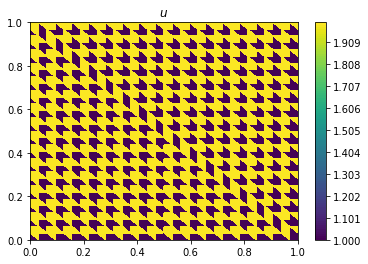

In [19]:
vmin, vmax = 1, 2.00001
levels = np.linspace(vmin, vmax, 100)
tc = tricontourf(u, vmin=vmin, vmax=vmax, levels=levels)
plt.colorbar(tc)
plt.title(r"$u$")

In [20]:
def recover_smooth(f, dt, K, mesh=None, target_spaces=None):
    mesh = mesh or f.function_space().mesh()
    if target_spaces is None:
        P1_vec = VectorFunctionSpace(mesh, "CG", 1)
    else:
        P1_vec = target_spaces[0]
    P0 = f.function_space()
    W = P0 * P1_vec
    v, phi = TestFunctions(W)
    solution = Function(W)
    f_sm, g = split(solution)
    n = FacetNormal(mesh)
    alpha = Constant(0.5)
    F = (inner(phi, g) * dx + f_sm * dot(phi, n) * ds - f_sm * div(phi) * dx 
        + avg(f_sm) * jump(phi, n) * dS # flux term (used to be -)
        + inner((f_sm - f)/dt, v) * dx - K * inner(div(g), v) * dx)
    solve(F == 0, solution)
    f_sm = Function(P0, val=solution.dat.data[0])
    g = Function(P1_vec, val=solution.dat.data[1])
    return f_sm, g

Text(0.5, 1.0, 'delX:0.0010, N:15.0, num_smooth:1')

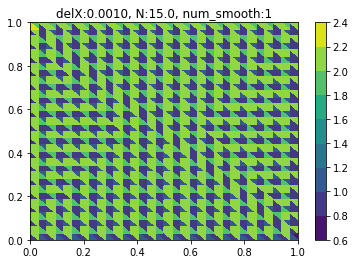

In [21]:
u = get_initial_condition(mesh, P0)
dt = 0.03125
delX = (1 / (n**2))
N = 15
K = Constant(N * delX**2 / dt)
num_smooth = 1
u_smooth, u_grad = None, None
for k in range(num_smooth):
    u_smooth, u_grad = recover_smooth(u, dt, K)
    u.assign(u_smooth)
    
plot_title = r"delX:{:.4f}, N:{:.1f}, num_smooth:{}".format(delX, N, num_smooth)
tc = tricontourf(u_smooth)
plt.colorbar(tc)
plt.title(plot_title)